## Feature Importance Division

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import plot_importance, plot_tree
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score ,RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFE
from catboost import CatBoostRegressor
import shap

import warnings
warnings.filterwarnings('ignore')

### Load and view data

In [2]:
OD = pd.read_excel("../Updated Variable list github/gabe/Modeling/Outputs/all_riders_vars_dataframe.xlsx").drop('Unnamed: 0', axis=1)

* Split the dataset into train, test, and val set

In [3]:
pd.reset_option('all')

In [4]:
OD = OD.groupby('pairs').first().reset_index()

In [5]:
OD.rename({'proportionhouses_O': 'proportion_of_households_O', 
           'proportionhouses_D': 'proportion_of_households_D'}, axis=1, inplace=True)

In [6]:
OD.head()

,pairs,passengers,ID_D,PRIMARY_NAME_FY23_D,walkshed_filename_D,WMATA_filename_D,track_miles_names_D,auto_filename_D,ID_O,PRIMARY_NAME_FY23_O,...,highschoolenroll_O,college_enroll_O,High_School_hh_O,college_hh_O,HH_0_car_O,HH_1_car_O,HH_more1_car_O,pub_admin_jobs_O,housing_units_afford_O,urban_dummy_O
0,MSTN_0010MSTN_002,1418,MSTN_002,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,Archives-Navy Memorial,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
1,MSTN_0010MSTN_003,156,MSTN_003,Benning Road,BENNING ROAD,Benning Road,Benning Road,BENNING ROAD,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
2,MSTN_0010MSTN_004,425,MSTN_004,Brookland-CUA,BROOKLAND-CUA,Brookland,Brookland-CUA,BROOKLAND-CUA,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
3,MSTN_0010MSTN_005,146,MSTN_005,Capitol South,CAPITOL SOUTH,Capitol South,Capitol South,CAPITOL SOUTH,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
4,MSTN_0010MSTN_006,124,MSTN_006,Cleveland Park,CLEVELAND PARK,Cleveland Park,Cleveland Park,CLEVELAND PARK,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0


In [7]:
OD.shape

(8187, 122)

In [8]:
OD.drop(['pairs', 'ID_D', 'PRIMARY_NAME_FY23_D', 'walkshed_filename_D', 'WMATA_filename_D', 
           'track_miles_names_D', 'auto_filename_D', 'ID_O', 'PRIMARY_NAME_FY23_O', 'walkshed_filename_O', 
             'WMATA_filename_O', 'track_miles_names_O', 'auto_filename_O', 'O', 'D', 'O_MSTN_ID', 'D_MSTN_ID', 
             'MSTN_ID_D', 'STATION_ID_D', 'Name_1_D', 'MSTN_D', 'MSTN_ID_O', 'STATION_ID_O', 'Name_1_O', 'MSTN_O', 
              'Total Households_O', 'Total Households_D', 'COMP_MILE', 'track_miles', 'SD_FARE', 'TRAVEL_TIME', 'pub_admin_jobs_O', 
            'pub_admin_jobs_D', 'bus_tt_per_mile', 'am_parking_user', 'pm_parking_user', 'off_parking_user', 'peak_fare_per_mile2',
            'off_peak_fare_per_mile', 'google_driving_miles', 'am_new_auto_tt_per_mile2', 'pm_new_auto_tt_per_mile2', 'off_new_auto_tt_per_mile2',
             'OFF_PEAK_FARE', 'PEAK_FARE', 'HH_1_car_O', 'HH_1_car_D', 'HH_more1_car_O', 'HH_more1_car_D', 'metro_swipe_tt'
          ], axis=1, inplace=True)

OD.shape

(8187, 72)

### Preprocessing

In [9]:
X = OD.drop('passengers', axis=1)
y = OD['passengers']

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.reset_option('all')

In [11]:
X.isna().any().sum()

30

In [12]:
y.isna().any().sum()

0

In [13]:
X = X.fillna(0.000001)

### Remove highly collinear variables

* 16 of these variables were dropped and due to very high multicollinearity and risk of endogeneity problem

In [14]:
# Xcorr = X.corr()
# plt.figure(figsize=(35, 30))
# sns.heatmap(Xcorr, cmap='coolwarm')

In [15]:
X1 = X.copy()

X1 = X1.drop(['All_Jobs_O', 'All_Jobs_D', 'ctpp_jobs_O', 'ctpp_jobs_D', 'urban_dummy_O', 'urban_dummy_D', 'terminal_dummy_2023_O', 
              'terminal_dummy_2023_D', 'AM_AVG_TRAINS_O',  'AM_AVG_TRAINS_D', 'PM_AVG_TRAINS_O', 'PM_AVG_TRAINS_D', 'am_new_auto_tt2', 
              'pm_new_auto_tt2', 'off_new_auto_tt2','bus_transit_minutes', ], axis=1)


In [16]:
# corr_matrix1 = X1.corr()
# plt.figure(figsize=(35, 30))
# mask1 = np.triu(np.ones_like(corr_matrix1, dtype=bool))
# sns.heatmap(corr_matrix1, mask=mask1, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
# plt.savefig('1corr_mat.png')
# plt.show()

In [17]:
# mask1 = (corr_matrix1 > 0.6) & (corr_matrix1 < 1)
# pairs1 = corr_matrix[mask1].stack().reset_index()
# pairs1.columns = ['Variable1', 'Variable2', 'Correlation']
# pairs1.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

In [18]:
# vif_data1 = pd.DataFrame()
# vif_data1["feature"] = X1.columns

# vif_data1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]

# vif_data1["VIF"] = vif_data1["VIF"].astype('float')
# vif_data1 = vif_data1.sort_values(by='VIF').reset_index(drop=True)
# vif_data1["VIF"] = vif_data1["VIF"].astype('str')
# vif_data1

## Modelling

In [19]:
X1.shape

(8187, 55)

#### Subset the DF in 30, 40, 45, ..... features

In [ ]:
feat_50 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes', 'bus_competativeness_index', 
           'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D', 'PARKING_CAPACITY_D', 'bus_line_count_D',
           'bus_stop_count_D', 'distance_to_core_D', 'Proportion_night_weekend_jobs_D', 'Total_Nine_to_Five_workers_D',
           'Proportion_education_jobs_D', 'Median_household_income_D', 'bike_cap_D', 'HH_below_50k_D', 'hotelcount_D',
           'entertainmentcount_D', 'restaurantcount_D', 'intercityhub_D', 'prop_str_dens_D', 'Jobs_transit_D',
           'convenience_storecount_D', 'highschoolenroll_D', 'college_enroll_D', 'HH_0_car_D', 'housing_units_afford_D',
           'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O',
           'bus_stop_count_O', 'distance_to_core_O', 'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
           'Proportion_education_jobs_O', 'Median_household_income_O', 'bike_cap_O', 'HH_below_50k_O', 'hotelcount_O',
           'entertainmentcount_O', 'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O', 'Jobs_transit_O',
           'highschoolenroll_O', 'college_enroll_O', 'HH_0_car_O', 'housing_units_afford_O']


X1_50 = X1[feat_50]

In [ ]:
X1_50.shape

In [97]:
feat_45 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes', 'bus_competativeness_index',
           'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D', 'PARKING_CAPACITY_D', 'bus_line_count_D', 
           'bus_stop_count_D', 'distance_to_core_D', 'Proportion_night_weekend_jobs_D', 'Total_Nine_to_Five_workers_D',
           'Proportion_education_jobs_D', 'Median_household_income_D', 'bike_cap_D', 'hotelcount_D', 
           'entertainmentcount_D', 'restaurantcount_D', 'intercityhub_D', 'prop_str_dens_D', 'Jobs_transit_D', 
           'highschoolenroll_D', 'HH_0_car_D', 'housing_units_afford_D', 'ALLPERIODS_AVG_TRAINS_O', 
           'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O', 'bus_stop_count_O', 'distance_to_core_O', 
           'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O', 'Proportion_education_jobs_O',
           'Median_household_income_O', 'bike_cap_O', 'HH_below_50k_O', 'hotelcount_O', 'entertainmentcount_O', 
           'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O', 'Jobs_transit_O', 'HH_0_car_O',
           'housing_units_afford_O']


X1_45 = X1[feat_45]

In [ ]:
X1_45.shape

In [70]:
feat_40 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes', 'bus_competativeness_index', 
           'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D', 'PARKING_CAPACITY_D', 'bus_line_count_D', 
           'bus_stop_count_D', 'distance_to_core_D', 'Proportion_night_weekend_jobs_D', 'Total_Nine_to_Five_workers_D',
           'Proportion_education_jobs_D', 'Median_household_income_D', 'bike_cap_D', 'hotelcount_D', 'restaurantcount_D',
           'intercityhub_D', 'prop_str_dens_D', 'HH_0_car_D', 'housing_units_afford_D', 'ALLPERIODS_AVG_TRAINS_O', 
           'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O', 'distance_to_core_O', 
           'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O', 'Proportion_education_jobs_O', 
           'Median_household_income_O', 'bike_cap_O', 'hotelcount_O', 'entertainmentcount_O', 'restaurantcount_O', 
           'intercityhub_O', 'prop_str_dens_O', 'Jobs_transit_O', 'HH_0_car_O', 'housing_units_afford_O']


X1_40 = X1[feat_40]

In [ ]:
X1_40.shape

In [ ]:
feat_30 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes', 'bus_competativeness_index',
        'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D','PARKING_CAPACITY_D', 'bus_line_count_D', 'distance_to_core_D',
        'Proportion_night_weekend_jobs_D', 'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D', 'bike_cap_D', 'hotelcount_D',
        'restaurantcount_D', 'intercityhub_D', 'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
        'PARKING_CAPACITY_O', 'distance_to_core_O','Total_Nine_to_Five_workers_O', 'Median_household_income_O',
        'bike_cap_O', 'hotelcount_O', 'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O']

X1_30 = X1[feat_30]

feat_35 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'PARKING_CAPACITY_D', 'bus_line_count_D', 'distance_to_core_D',
       'Proportion_night_weekend_jobs_D', 'Total_Nine_to_Five_workers_D',
       'Proportion_education_jobs_D', 'Median_household_income_D',
       'bike_cap_D', 'hotelcount_D', 'restaurantcount_D', 'intercityhub_D',
       'prop_str_dens_D', 'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O',
       'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O',
       'distance_to_core_O', 'Proportion_night_weekend_jobs_O',
       'Total_Nine_to_Five_workers_O', 'Median_household_income_O',
       'bike_cap_O', 'hotelcount_O', 'restaurantcount_O', 'intercityhub_O',
       'prop_str_dens_O', 'Jobs_transit_O', 'HH_0_car_O']

X1_35 = X1[feat_35]

In [ ]:
X1_30.shape

In [ ]:
feat_10 = ['metro_transit_minutes', 'intercityhub_O', 'intercityhub_D', 'bike_traveltime', 'google_driving_minutes', 
 'bus_competativeness_index', 'Total_Nine_to_Five_workers_O', 'Total_Nine_to_Five_workers_D', 'HH_0_car_D', 'bus_tt']

X1_10 = X1[feat_10]

In [ ]:
X1_10.shape

In [ ]:
# set(X1.columns.to_list()) - set(X1_25.columns.to_list())

set(X1.columns.to_list()) - set(X1_40.columns.to_list())

In [ ]:
# rfe_baseModel = RandomForestRegressor(random_state=10)
# rfe = RFE(estimator=rfe_baseModel, n_features_to_select=15, step=1)  # Selecting top 10 features
# rfe.fit(X1, y)
# rfe_cols = X1.columns[rfe.support_]

In [ ]:
# rfe_cols

In [143]:
X1_5_rfe = X1[['bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes',
       'bus_competativeness_index', 'intercityhub_D']]


X1_10_rfe = X1[['bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes',
       'bus_competativeness_index', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'intercityhub_D', 'distance_to_core_O',
       'Total_Nine_to_Five_workers_O', 'intercityhub_O']]


X1_15_rfe = X1[['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'proportion_of_households_D', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'intercityhub_D', 'HH_0_car_D',
       'proportion_of_households_O', 'distance_to_core_O',
       'Total_Nine_to_Five_workers_O', 'intercityhub_O', 'HH_0_car_O']]

X1_20 = X1[['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'distance_to_core_D', 'Total_Nine_to_Five_workers_D', 'bike_cap_D',
       'intercityhub_D', 'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O',
       'proportion_of_households_O', 'distance_to_core_O',
       'Total_Nine_to_Five_workers_O', 'bike_cap_O', 'restaurantcount_O',
       'intercityhub_O', 'HH_0_car_O']]

X1_25 = X1[['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'PARKING_CAPACITY_D', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
       'bike_cap_D', 'hotelcount_D', 'restaurantcount_D', 'intercityhub_D',
       'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
       'distance_to_core_O', 'Total_Nine_to_Five_workers_O', 'bike_cap_O',
       'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O']]

tX1_25 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'PARKING_CAPACITY_D', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
       'bike_cap_D', 'restaurantcount_D', 'intercityhub_D', 'HH_0_car_D',
       'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
       'PARKING_CAPACITY_O', 'distance_to_core_O',
       'Total_Nine_to_Five_workers_O', 'bike_cap_O', 'restaurantcount_O',
       'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O']


"""
25 features categories: 
    Jobs: *9-5 jobs, proportion education jobs
    Education: N/A
    Amenities: hotel, *restaurant
    Urban Form: *Distance to the core, intersection density
    Transport and Acc: *Bikeshare station capacity, *intercity hub, parking capacity
    Housing: N/A
    Socio-economic: *Number of households, *Households with no car
    Mode competition: bus traveltime, bike traveltime, auto traveltime, metro rail traveltime, bus competitiveness index
    Convinience: *Average trains per hour  
"""


'\n25 features categories: \n    Jobs: *9-5 jobs, proportion education jobs\n    Education: N/A\n    Amenities: hotel, *restaurant\n    Urban Form: *Distance to the core, intersection density\n    Transport and Acc: *Bikeshare station capacity, *intercity hub, parking capacity\n    Housing: N/A\n    Socio-economic: *Number of households, *Households with no car\n    Mode competition: bus traveltime, bike traveltime, auto traveltime, metro rail traveltime, bus competitiveness index\n    Convinience: *Average trains per hour  \n'

In [144]:
sorted(tX1_25)

['ALLPERIODS_AVG_TRAINS_D',
 'ALLPERIODS_AVG_TRAINS_O',
 'HH_0_car_D',
 'HH_0_car_O',
 'PARKING_CAPACITY_D',
 'PARKING_CAPACITY_O',
 'Proportion_education_jobs_D',
 'Total_Nine_to_Five_workers_D',
 'Total_Nine_to_Five_workers_O',
 'bike_cap_D',
 'bike_cap_O',
 'bike_traveltime',
 'bus_competativeness_index',
 'bus_tt',
 'distance_to_core_D',
 'distance_to_core_O',
 'google_driving_minutes',
 'intercityhub_D',
 'intercityhub_O',
 'metro_transit_minutes',
 'prop_str_dens_O',
 'proportion_of_households_D',
 'proportion_of_households_O',
 'restaurantcount_D',
 'restaurantcount_O']

In [145]:
sorted(X1_25.columns.to_list())

['ALLPERIODS_AVG_TRAINS_D',
 'ALLPERIODS_AVG_TRAINS_O',
 'HH_0_car_D',
 'HH_0_car_O',
 'PARKING_CAPACITY_D',
 'Proportion_education_jobs_D',
 'Total_Nine_to_Five_workers_D',
 'Total_Nine_to_Five_workers_O',
 'bike_cap_D',
 'bike_cap_O',
 'bike_traveltime',
 'bus_competativeness_index',
 'bus_tt',
 'distance_to_core_D',
 'distance_to_core_O',
 'google_driving_minutes',
 'hotelcount_D',
 'intercityhub_D',
 'intercityhub_O',
 'metro_transit_minutes',
 'prop_str_dens_O',
 'proportion_of_households_D',
 'proportion_of_households_O',
 'restaurantcount_D',
 'restaurantcount_O']

#### Split the data to a train, validation, holdout test set

* Create an initial split - training and temporary test set
* Create secondary split: this would be the training and validation set from the X_train_temp

In [101]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X1, y, test_size=0.10, random_state = 10)

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.15, random_state=10)

In [103]:
X_train.shape, X_val.shape, X_test.shape

((6262, 55), (1106, 55), (819, 55))

##### Carry out RFE on the Train dataset

In [146]:
%time 
rfe_baseModel = RandomForestRegressor(random_state=10)
rfe = RFE(estimator=rfe_baseModel, n_features_to_select=28, step=1)  # Selecting top 10 features
rfe.fit(X_train, y_train)
rfe_cols = X_train.columns[rfe.support_]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [147]:
rfe_cols

Index(['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'PARKING_CAPACITY_D', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
       'bike_cap_D', 'hotelcount_D', 'restaurantcount_D', 'intercityhub_D',
       'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
       'PARKING_CAPACITY_O', 'distance_to_core_O',
       'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
       'Median_household_income_O', 'bike_cap_O', 'restaurantcount_O',
       'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O'],
      dtype='object')

In [125]:
X_train = X_train[rfe_28]

In [126]:
X_test = X_test[rfe_28]

In [127]:
X_val = X_val[rfe_28]

In [128]:
X_train.shape, X_val.shape, X_test.shape

((6262, 28), (1106, 28), (819, 28))

In [108]:
# X1_40.columns

In [122]:
rfe_28 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'PARKING_CAPACITY_D', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
       'bike_cap_D', 'hotelcount_D', 'restaurantcount_D', 'intercityhub_D',
       'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
       'PARKING_CAPACITY_O', 'distance_to_core_O',
       'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
       'Median_household_income_O', 'bike_cap_O', 'restaurantcount_O',
       'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O']

In [124]:
set(rfe_28) - set(X1_25.columns.to_list())

{'Median_household_income_O',
 'PARKING_CAPACITY_O',
 'Proportion_night_weekend_jobs_O'}

* Train the random forest model and tune on the validation set
* Evaluate the RF model on holdout set. not previously seen by the model
* Generate feature importance plots - color the feature importance plot by categories for more intuition

#### vanilla random forest model

In [129]:
regr = RandomForestRegressor(random_state=10)

# bootstrap=False, max_depth=20, max_features= 'sqrt', 
#                              min_samples_leaf= 1, min_samples_split = 2, n_estimators= 200  # 40 features best hyperparams grid

# bootstrap= False, max_depth=30, max_features= 'sqrt', min_samples_leaf=1, min_samples_split= 2, n_estimators= 200

In [130]:
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [131]:
y_pred = regr.predict(X_val)

In [132]:
rmse = sqrt(mean_squared_error(y_val, y_pred))
rmse

679.6591953036165

In [133]:
np.round(r2_score(y_val, y_pred), 3)

0.716

#### Evaluate model on holdout test set

In [134]:
test_pred = regr.predict(X_test)

In [135]:
rmse = sqrt(mean_squared_error(y_test, test_pred))

In [136]:
rmse

615.0443300030206

In [137]:
np.round(r2_score(y_test, test_pred), 3)

0.738

#### k fold cross-validation

In [139]:
X_28 = X1[rfe_28]

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

reg = RandomForestRegressor(random_state=10)

scores = cross_val_score(reg, X_28, y, cv=kfold, scoring='r2')

# bootstrap= False, max_depth=30, max_features= 'sqrt', 
#                              min_samples_leaf=1, min_samples_split= 2, n_estimators= 200

In [140]:
print(f"R-squared: {scores.mean():.2f}")

R-squared: 0.70


In [141]:
scores

array([0.73501901, 0.70646378, 0.70251769, 0.68414016, 0.69503497])

### Explore SHAP Feature Importance

In [149]:
rf_reg = RandomForestRegressor(random_state=10)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [150]:
explainer = shap.Explainer(rf_reg, X_train)
shap_values = explainer(X_val, check_additivity=False) 

100%|===================| 1102/1106 [01:02<00:00]        

In [151]:
# Visualize the first prediction's explanation (as an example)
shap.initjs()  # Required for visualization in Jupyter Notebooks and Labs
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_val.iloc[0,:])

In [152]:
X_val.shape

(1106, 28)

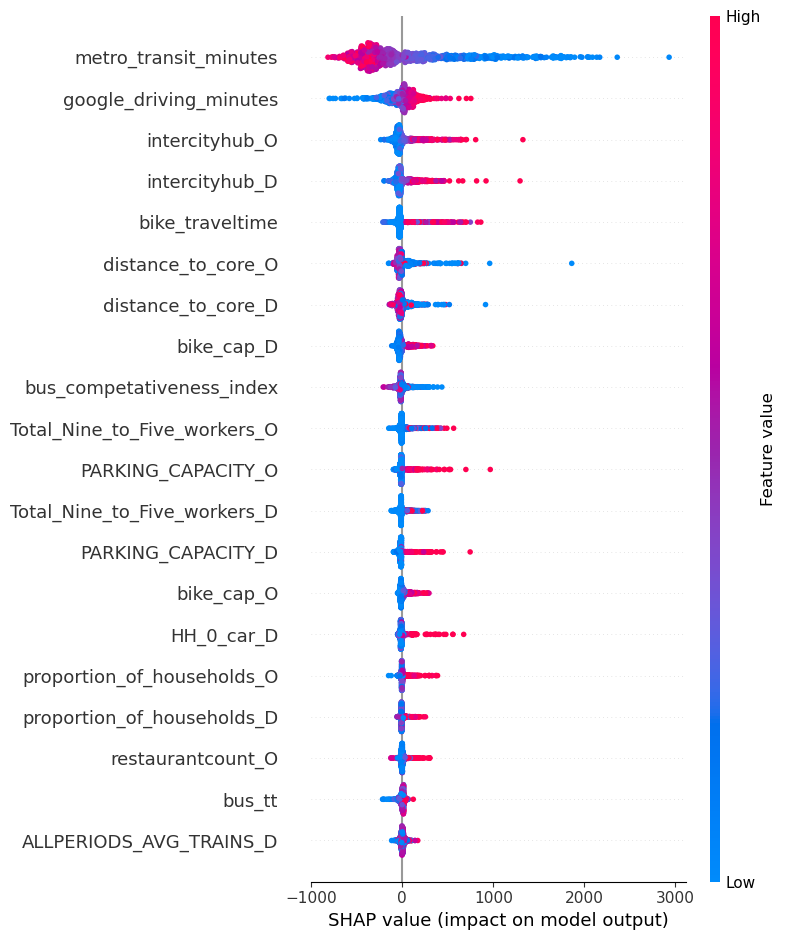

In [153]:
shap.summary_plot(shap_values, X_val, plot_type="dot")

In [ ]:
# # sorted(X1_25.columns.to_list())
# corr_matrix1 = X1_25.corr()
# plt.figure(figsize=(35, 30))
# mask1 = np.triu(np.ones_like(corr_matrix1, dtype=bool))
# sns.heatmap(corr_matrix1, mask=mask1, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
# # plt.savefig('1corr_mat.png')
# plt.show()

### Generate Feature Importance Metric

In [ ]:
# importances = regr.feature_importances_

In [ ]:
# importances

In [ ]:
# indices = np.argsort(importances)[::-1][:10]

In [ ]:
# indices

In [ ]:
# names = [X1_20.columns[i] for i in indices]

In [ ]:
# plt.figure(figsize=(10, 7))
# plt.title("(20 Features) Feature Importance")
# plt.barh(range(10), importances[indices], align='center')
# plt.yticks(range(10), names, size=12)
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
# plt.tight_layout()
# plt.savefig('Feature_importance/20 features importance.jpg')
# plt.show()

In [ ]:
# 